In [32]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt



### Load Data

In [33]:
exp3_df = pd.read_csv('../../data/deGraaf_and_Malle.csv', sep=';')

# ignore nans
human_avg_ratings =  {"Intentionality Robot": exp3_df.loc[exp3_df['Experiment'] == 'Robot (sim)', 'Intentionality'].values, "Surprisingness Robot": exp3_df.loc[exp3_df['Experiment'] == 'Robot (sim)', 'Surprisingness'].values, "Desirability Robot": exp3_df.loc[exp3_df['Experiment'] == 'Robot (sim)', 'Desirability'].values, "Intentionality Human": exp3_df.loc[exp3_df['Experiment'] == 'Human (sim)', 'Intentionality'].values, "Surprisingness Human": exp3_df.loc[exp3_df['Experiment'] == 'Human (sim)', 'Surprisingness'].values, "Desirability Human": exp3_df.loc[exp3_df['Experiment'] == 'Human (sim)', 'Desirability'].values}

human_difference_ratings = {"Intentionality": exp3_df['Dif Intentionality'].dropna().values, "Surprisingness": exp3_df['Dif Surprisingness'].dropna().values, "Desirability": exp3_df['Dif Desirability'].dropna().values}

indices_robot_sim = exp3_df.index[exp3_df['Experiment'] == 'Robot (sim)'].tolist()
indices_human_sim = exp3_df.index[exp3_df['Experiment'] == 'Human (sim)'].tolist()
indices_robot_diff = exp3_df.index[exp3_df['Experiment'] == 'Robot (dif)'].tolist()
indices_human_diff = exp3_df.index[exp3_df['Experiment'] == 'Human (dif)'].tolist()
print(indices_robot_sim)
print(indices_human_sim)
print(indices_robot_diff)
print(indices_human_diff)


exp3_df.head()


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]


,Experiment,Stimulus,Intentionality,Surprisingness,Desirability,Dif Intentionality,Dif Surprisingness,Dif Desirability
0,Robot (sim),A robot nurse is taking care of an ill young b...,3.6,4.1,3.6,NaN,NaN,NaN
1,Robot (sim),A security robot is walking on the sidewalk. W...,4.7,3.1,3.8,NaN,NaN,NaN
2,Robot (sim),A robot is working on its supervisor’s compute...,2.8,6.4,-3.9,NaN,NaN,NaN
3,Robot (sim),A personal assistant robot is sorting through ...,2.1,5.3,-1.8,NaN,NaN,NaN
4,Robot (sim),A robot host is standing at the entrance of th...,4.6,2.2,3.6,NaN,NaN,NaN


In [34]:
def load_from_csv(model_name):
    df = pd.read_csv(f"model_completions/{model_name}.csv")
    model_scores = df.to_dict(orient="list")
    model_avg_ratings =  {"Intentionality Robot": [], "Surprisingness Robot": [], "Desirability Robot": [], "Intentionality Human": [], "Surprisingness Human": [], "Desirability Human": []}
    # fill it based on the right indices
    for i in indices_robot_sim:
        model_avg_ratings["Intentionality Robot"].append(model_scores["Intentionality"][i])
        model_avg_ratings["Surprisingness Robot"].append(model_scores["Surprisingness"][i])
        model_avg_ratings["Desirability Robot"].append(model_scores["Desirability"][i])
    for i in indices_human_sim:
        model_avg_ratings["Intentionality Human"].append(model_scores["Intentionality"][i])
        model_avg_ratings["Surprisingness Human"].append(model_scores["Surprisingness"][i])
        model_avg_ratings["Desirability Human"].append(model_scores["Desirability"][i])
    
    model_difference_ratings = {"Intentionality": [], "Surprisingness": [], "Desirability": []}
    # substract robot from human score
    for i in indices_human_diff:
        model_difference_ratings["Intentionality"].append(model_scores["Intentionality"][i])
        model_difference_ratings["Surprisingness"].append(model_scores["Surprisingness"][i])
        model_difference_ratings["Desirability"].append(model_scores["Desirability"][i])
    for i, ind in enumerate(indices_robot_diff):
        model_difference_ratings["Intentionality"][i]-=model_scores["Intentionality"][ind]
        model_difference_ratings["Surprisingness"][i]-=model_scores["Surprisingness"][ind]
        model_difference_ratings["Desirability"][i]-=model_scores["Desirability"][ind]


    return model_avg_ratings, model_difference_ratings

In [35]:
# df column Intentionality where Experiment columns says "Robot (sim)"
exp3_df.loc[exp3_df['Experiment'] == 'Robot (sim)', 'Intentionality'].values

array([ 3.6,  4.7,  2.8,  2.1,  4.6,  4.6,  3.1,  3.8,  4.9,  2.9, -2.6,
       -4.1, -2.7, -4.3])

In [36]:
human_avg_ratings

{'Intentionality Robot': array([ 3.6,  4.7,  2.8,  2.1,  4.6,  4.6,  3.1,  3.8,  4.9,  2.9, -2.6,
        -4.1, -2.7, -4.3]),
 'Surprisingness Robot': array([4.1, 3.1, 6.4, 5.3, 2.2, 2.2, 2.8, 1.9, 1.9, 2.7, 5.1, 4.9, 3.7,
        3.1]),
 'Desirability Robot': array([ 3.6,  3.8, -3.9, -1.8,  3.6,  3.5,  1.7,  2.9,  3.6,  0. ,  1.6,
        -4.5,  2.1, -1.8]),
 'Intentionality Human': array([ 4.7,  4.7,  4.5,  3.1,  4.8,  4.7,  3.4,  2.2,  4.5,  4.5, -3.6,
        -3.6, -3.1, -4.1]),
 'Surprisingness Human': array([3.8, 3.9, 4.9, 4.8, 1.7, 1.5, 2.7, 2.4, 1.7, 2.7, 5.8, 5.2, 5.2,
        2.7]),
 'Desirability Human': array([ 4.1,  3.5, -3.9, -1. ,  3.1,  3.5,  0.8,  2. ,  4.2,  0.8,  1.9,
        -4.6,  1.9, -1. ])}

In [37]:
human_difference_ratings

{'Intentionality': array([ 0.11,  1.89,  1.35,  0.88,  2.41,  2.7 ,  3.77,  0.29,  0.6 ,
        -7.17,  5.62,  3.98,  2.2 ,  3.8 ,  2.07,  3.46,  4.09]),
 'Surprisingness': array([-1.14,  0.39, -1.37, -0.34, -0.89, -1.24, -2.7 ,  3.45, -4.11,
         1.73, -0.23,  0.75,  0.58, -0.6 ,  1.22,  1.53, -1.81]),
 'Desirability': array([-1.48 , -1.33 , -1.95 ,  1.58 ,  1.32 ,  1.79 ,  1.06 , -3.11 ,
         4.94 , -6.41 ,  4.53 , -2.61 ,  1.31 ,  0.373, -1.25 ,  1.76 ,
         3.98 ])}

In [82]:
model_avg_ratings_gpt4, model_difference_ratings_gpt4 = load_from_csv("gpt-4-0613_2024-01-15_")
model_avg_ratings_gpt35, model_difference_ratings_gpt35 = load_from_csv("gpt-3.5-turbo-0613_2024-01-19_")
model_avg_ratings_gpt3base, model_difference_ratings_gpt3base = load_from_csv("davinci-002_2024-01-15_")

model_avg_ratings_llama13, model_difference_ratings_llama13 = load_from_csv("l13b_chat_2024-01-18_")
model_avg_ratings_llama70, model_difference_ratings_llama70 = load_from_csv("l70b_chat_2024-01-20_")

model_avg_ratings_gpt4_cot, model_difference_ratings_gpt4_cot = load_from_csv("gpt-4-0613_2024-01-21_CoT")

In [60]:
def correct_non_answers(model_scores):
    """impute the median answer for values=99"""
    for key in model_scores:
        model_scores[key] = [x if abs(x)<50 else np.median(model_scores[key]) for x in model_scores[key]]
    return model_scores

model_avg_ratings_llama13, model_difference_ratings_llama13 = correct_non_answers(model_avg_ratings_llama13), correct_non_answers(model_difference_ratings_llama13)
model_avg_ratings_llama70, model_difference_ratings_llama70 = correct_non_answers(model_avg_ratings_llama70), correct_non_answers(model_difference_ratings_llama70)

In [9]:
model_avg_ratings_gpt35

{'Intentionality Robot': [5, 5, -4, -3, 5, 5, 4, 4, 5, 4, 5, -3, 4, -2],
 'Surprisingness Robot': [6, 6, 7, 5, 5, 4, 5, 4, 6, 4, 6, 6, 6, 5],
 'Desirability Robot': [5, 4, -5, -3, 5, 5, 5, 4, 5, 4, 4, -5, 5, -3],
 'Intentionality Human': [5, 4, -4, -2, 5, 5, 4, 3, 5, 4, 4, -3, 5, -2],
 'Surprisingness Human': [6, 6, 6, 3, 5, 4, 5, 4, 6, 4, 6, 6, 6, 4],
 'Desirability Human': [5, 4, -5, -2, 5, 5, 5, 4, -5, 4, 4, -5, 5, -3]}

In [10]:
model_difference_ratings_gpt35

{'Intentionality': [-1, -1, 0, -2, 1, 0, 1, -1, 0, 0, 0, 0, 0, 0, -5, 0, 0],
 'Surprisingness': [0, 0, -2, -1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'Desirability': [0, 0, -1, -1, 1, 0, 1, -1, 0, 0, -3, 1, 0, 0, 0, 0, 0]}

### Helper Functions

In [61]:
def compute_correlations(model_scores, user_scores, save_name="", plot = False, diff=False):
    correlations = []
    p_values = []
    corr_labels = []
    for key in model_scores.keys():
        print(key)
        correlation = stats.spearmanr(model_scores[key], user_scores[key])
        # check for nan
        if np.isnan(correlation[0]):
            correlations.append(0)
            p_values.append(1)
        else:
            correlations.append(correlation[0])
            p_values.append(correlation[1])
        c_label = key
        if diff:
            c_label+="_dif"
        corr_labels.append(c_label)
        print(correlation)
    if plot:
        # make scatter plot with 6 subplots
        if diff:
            fig, axs = plt.subplots(1, 3, figsize=(18, 4))
        else:
            fig, axs = plt.subplots(2, 3, figsize=(18, 8))
        fig.suptitle('Model vs. Human Scores')
        for i, key in enumerate(model_scores.keys()):
            # set grid and make it semi-transparent
            if diff:
                axs_i = axs[i%3]
            else:
                axs_i = axs[i//3, i%3]
            axs_i.grid(alpha=0.25)
            if diff:
                pass 
            # for first and third colum
            elif "Surprisingness" not in key:
                # make axis range from 1 to 5
                axs[i//3, i%3].set_xlim(-5.1, 5.1)
                axs[i//3, i%3].set_ylim(-5.1, 5.1)
                # set xticks and y ticks to 1 to 5
                axs[i//3, i%3].set_xticks(np.arange(-6, 6, 1))
                axs[i//3, i%3].set_yticks(np.arange(-6, 6, 1))
            else: 
                # make axis range from 1 to 5
                axs[i//3, i%3].set_xlim(0.9, 7.1)
                axs[i//3, i%3].set_ylim(0.9, 7.1)
                # set xticks and y ticks 
                axs[i//3, i%3].set_xticks(np.arange(1, 8, 1))
                axs[i//3, i%3].set_yticks(np.arange(1, 8, 1))
            # plot the scatter plot
            axs_i.scatter(model_scores[key], user_scores[key], color="Blue") #simple variant 
            axs_i.set_xlabel("Model Scores")
            axs_i.set_ylabel("Human Scores")
            axs_i.set_title(key)
            # add correlation as text to each plot
            correlation = stats.spearmanr(model_scores[key], user_scores[key])
            axs_i.text(0.05, 0.95, f"Correlation: {correlation[0]:.2f}", transform=axs_i.transAxes, fontsize=11, verticalalignment='top')
            # add mean absolute error as text to each plot
            mae = mean_absolute_error(model_scores[key], user_scores[key])
            axs_i.text(0.05, 0.85, f"MAE: {mae:.2f}", transform=axs_i.transAxes, fontsize=11, verticalalignment='top')
            # increase size between two rows
            fig.subplots_adjust(hspace=0.5)
        plt.show()
        # save the plot
        if save_name != "":
            fig.savefig(f"/plots/{save_name}.png")

    return correlations, p_values, corr_labels


### Result Analysis

In [73]:
all_p_values = []
all_correlations = []
all_corr_labels = []

Intentionality Robot
SignificanceResult(statistic=0.7891533651944587, pvalue=0.0007916655894999641)
Surprisingness Robot
SignificanceResult(statistic=0.8558880194746626, pvalue=9.411388879634059e-05)
Desirability Robot
SignificanceResult(statistic=0.8589437881128918, pvalue=8.333310690411682e-05)
Intentionality Human
SignificanceResult(statistic=0.7924391436708981, pvalue=0.0007260096329624042)
Surprisingness Human
SignificanceResult(statistic=0.8295733283055877, pvalue=0.0002424331917630247)
Desirability Human
SignificanceResult(statistic=0.8463762262449936, pvalue=0.0001351471703516413)


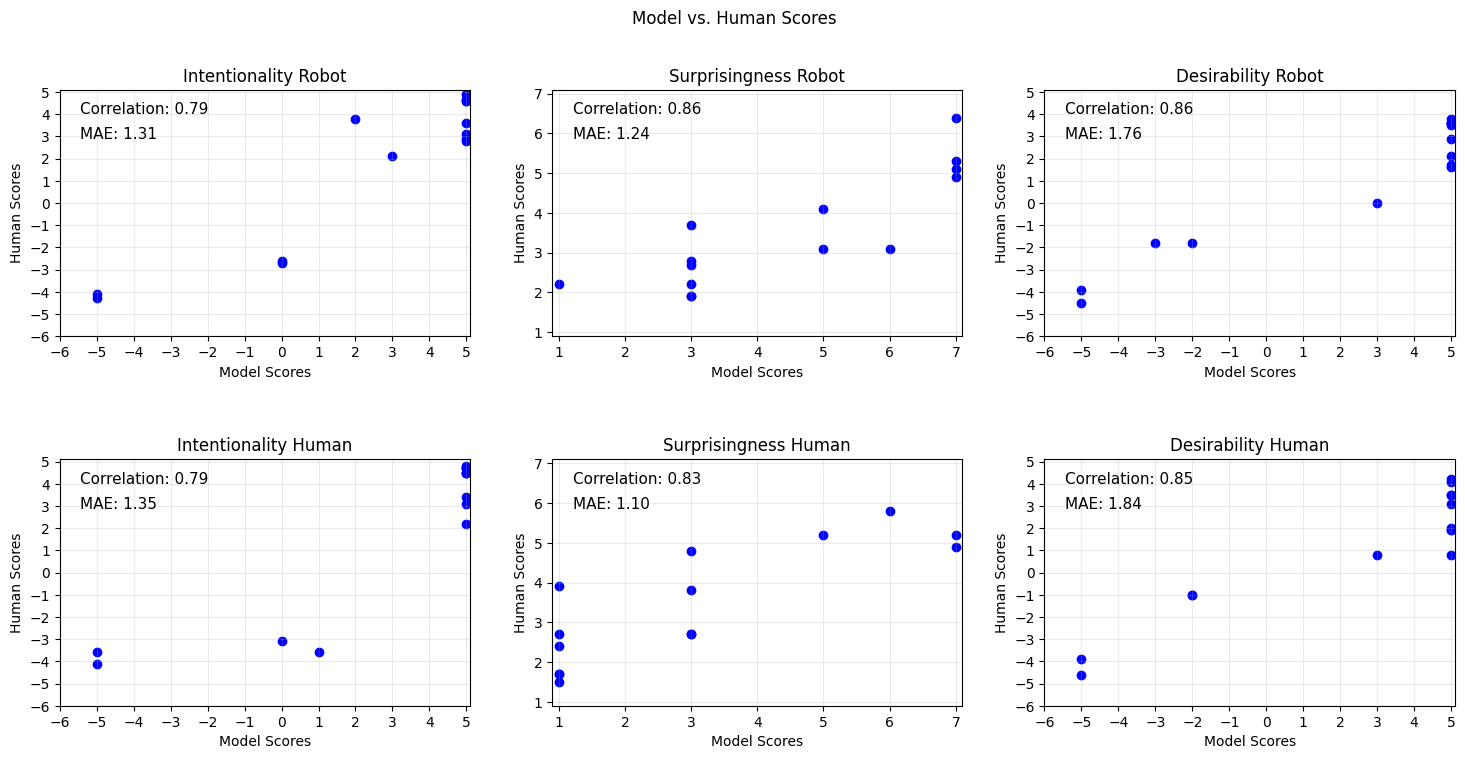

Avg: 0.8287289785005821
Intentionality
SignificanceResult(statistic=0.6396367083696356, pvalue=0.00569166326277789)
Surprisingness
SignificanceResult(statistic=0.0331030012815743, pvalue=0.8996332942520164)
Desirability
SignificanceResult(statistic=0.22732706991108964, pvalue=0.38023125937556)


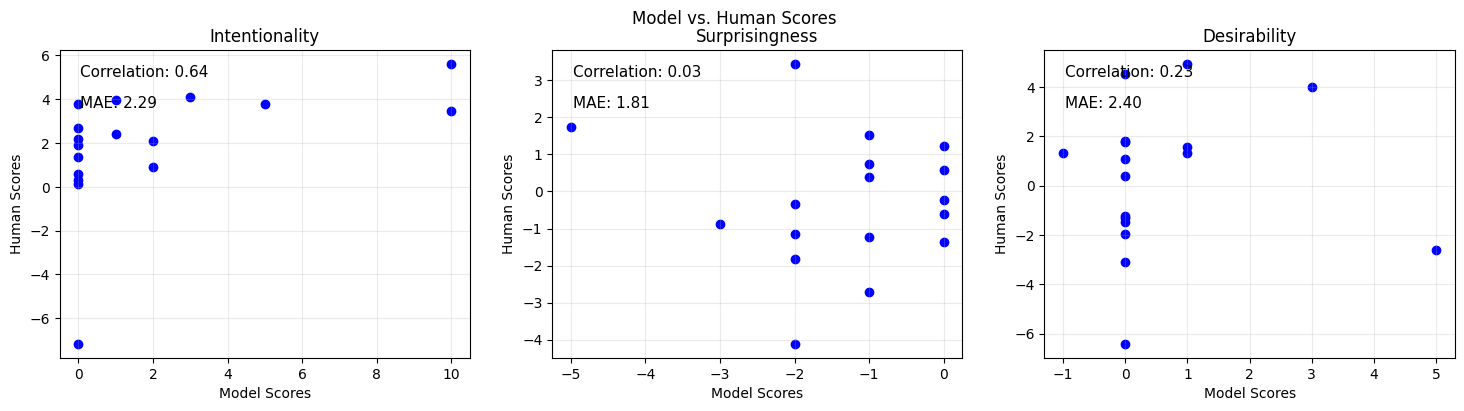

Avg: 0.30002225985409986


In [74]:
corrs, p_vals, coor_labels = compute_correlations(model_avg_ratings_gpt4, human_avg_ratings, plot=True)
print("Avg:", np.mean(corrs))
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt4")

corrs, p_vals, coor_labels = compute_correlations(model_difference_ratings_gpt4, human_difference_ratings, plot=True, diff=True)
print("Avg:", np.mean(corrs))
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt4")

Intentionality Robot
SignificanceResult(statistic=nan, pvalue=nan)
Surprisingness Robot
SignificanceResult(statistic=-0.3796652174370442, pvalue=0.18059465398990657)
Desirability Robot
SignificanceResult(statistic=nan, pvalue=nan)
Intentionality Human
SignificanceResult(statistic=nan, pvalue=nan)
Surprisingness Human
SignificanceResult(statistic=-0.3823063289770998, pvalue=0.17733080755726166)
Desirability Human
SignificanceResult(statistic=0.27642610854361105, pvalue=0.3387276765040219)


/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


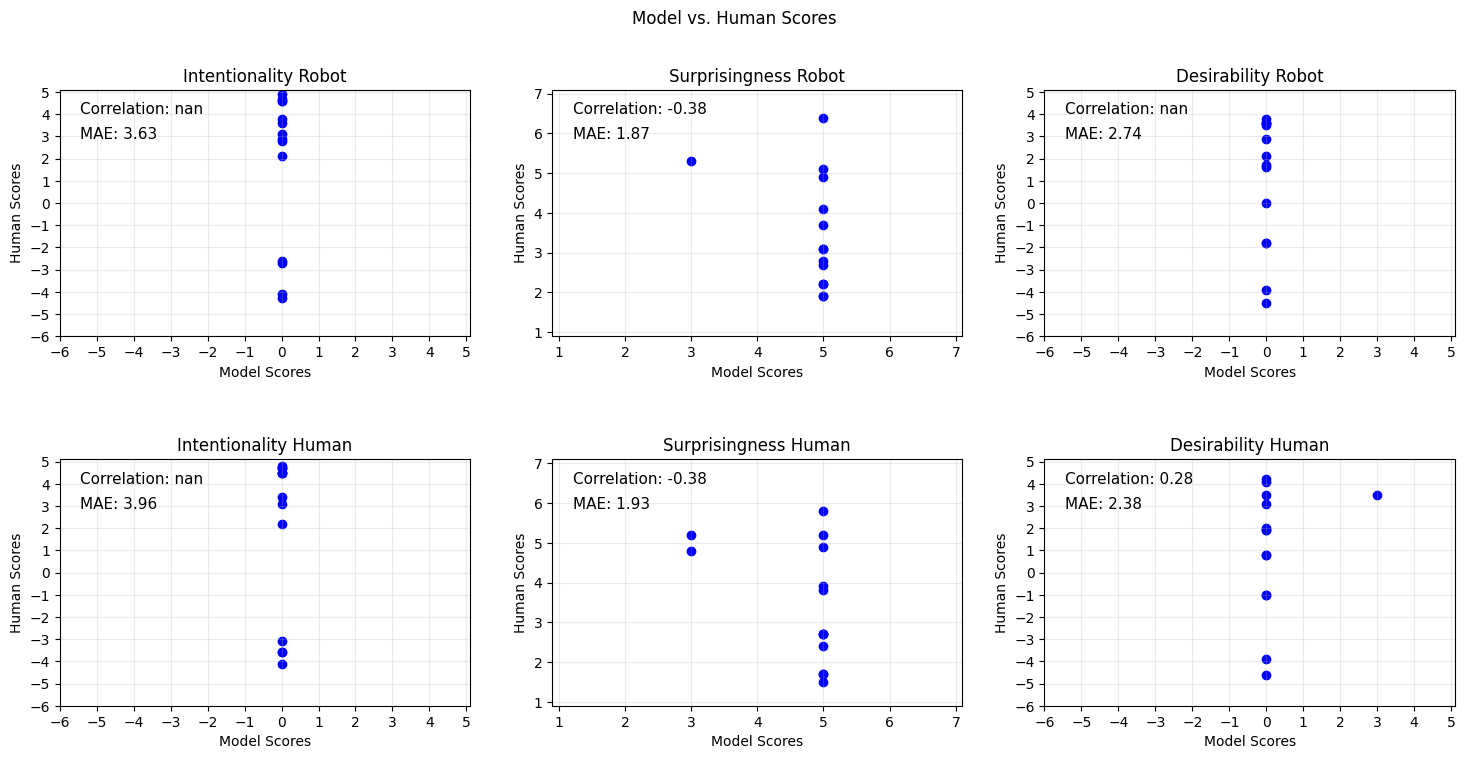

Avg: -0.08092423964508882
Intentionality
SignificanceResult(statistic=nan, pvalue=nan)
Surprisingness
SignificanceResult(statistic=-0.27684374724694194, pvalue=0.2820549408300578)
Desirability
SignificanceResult(statistic=nan, pvalue=nan)


/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/opt/homebrew/anaconda3/envs/hrillms/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


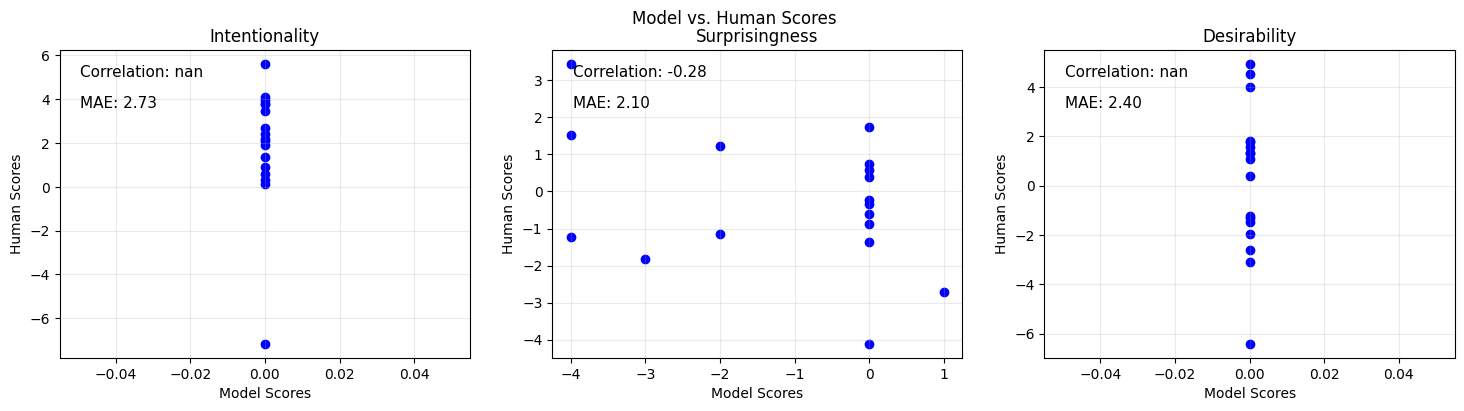

Avg: -0.09228124908231398


In [75]:
corrs, p_vals, coor_labels = compute_correlations(model_avg_ratings_gpt3base, human_avg_ratings, plot=True)
print("Avg:", np.mean(corrs))
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt3")

corrs, p_vals, coor_labels = compute_correlations(model_difference_ratings_gpt3base, human_difference_ratings, plot=True, diff=True)
print("Avg:", np.mean(corrs))
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt3")

Intentionality Robot
SignificanceResult(statistic=0.6961962413787613, pvalue=0.005678382803222942)
Surprisingness Robot
SignificanceResult(statistic=0.6022647870401615, pvalue=0.022657073771663427)
Desirability Robot
SignificanceResult(statistic=0.7654864459353119, pvalue=0.0014178936032332163)
Intentionality Human
SignificanceResult(statistic=0.5369533141519975, pvalue=0.047717308729747804)
Surprisingness Human
SignificanceResult(statistic=0.48755698220522686, pvalue=0.07698437113597058)
Desirability Human
SignificanceResult(statistic=0.8632178062888183, pvalue=6.995952760558072e-05)


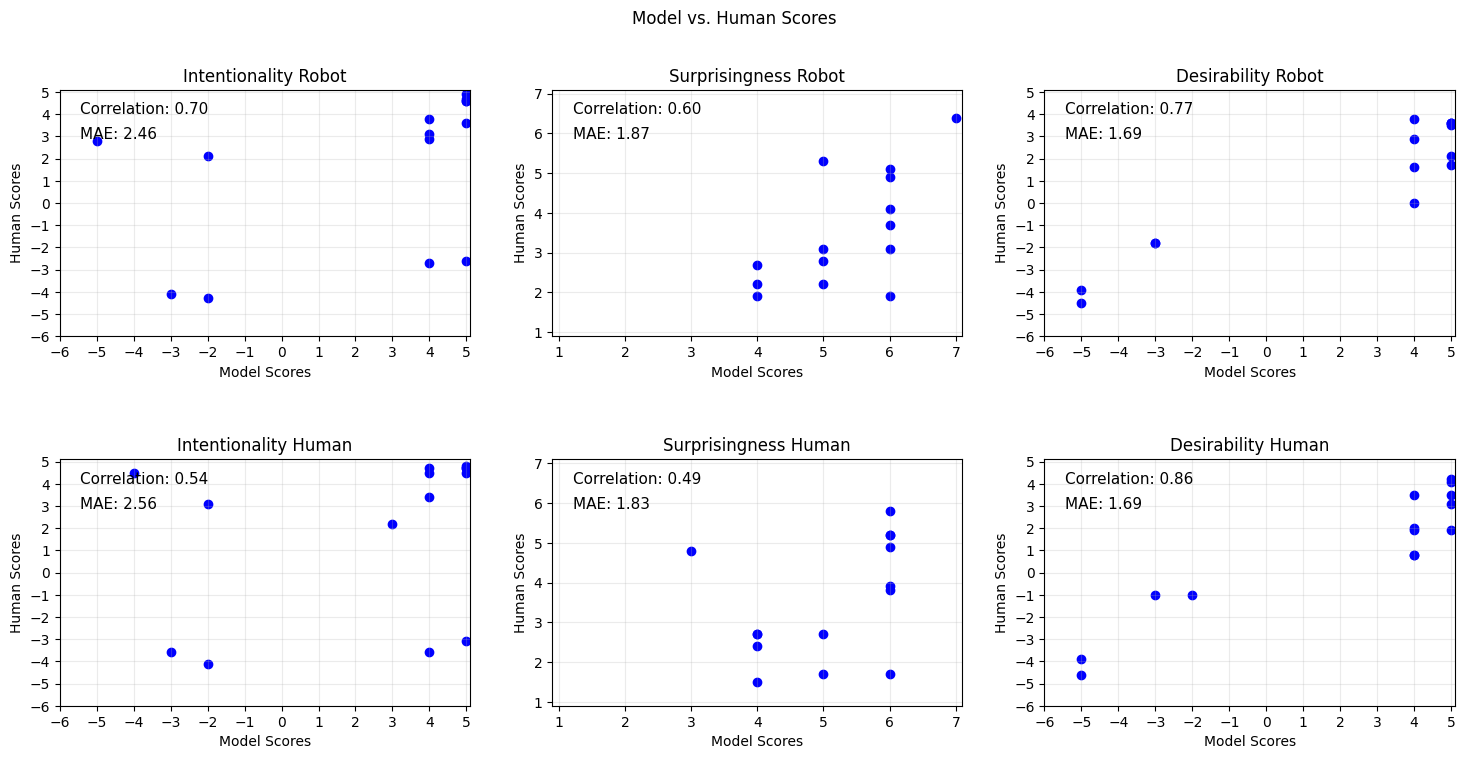

Avg: 0.658612596166713
Intentionality
SignificanceResult(statistic=0.4710475699425579, pvalue=0.05632029933321997)
Surprisingness
SignificanceResult(statistic=0.3214551697725512, pvalue=0.20833418834466658)
Desirability
SignificanceResult(statistic=-0.017279947800812524, pvalue=0.9475175276046416)


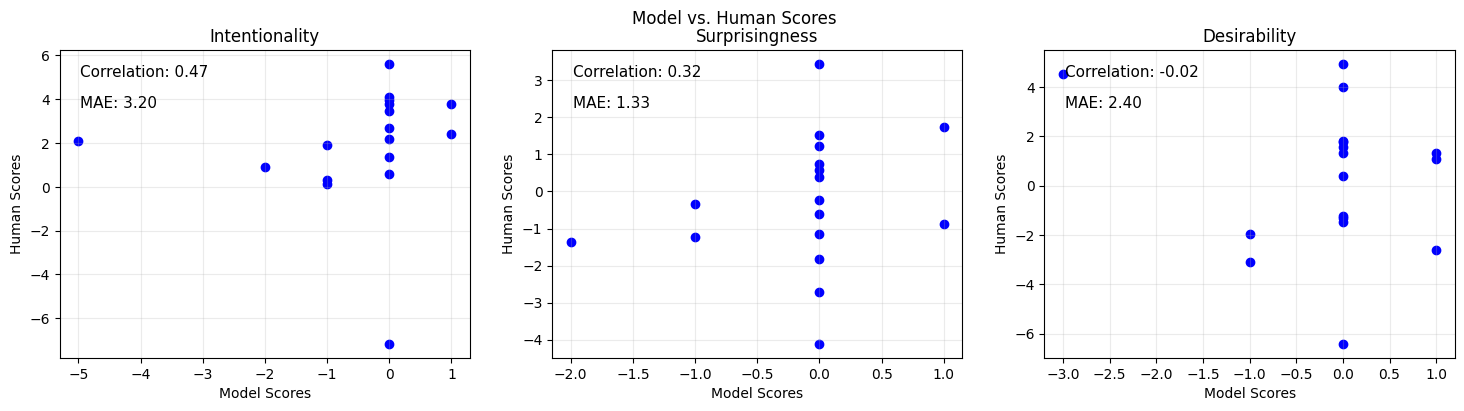

Avg: 0.25840759730476554


In [76]:
corrs, p_vals, coor_labels = compute_correlations(model_avg_ratings_gpt35, human_avg_ratings, plot=True)
print("Avg:", np.mean(corrs))
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt35")

corrs, p_vals, coor_labels = compute_correlations(model_difference_ratings_gpt35, human_difference_ratings, plot=True, diff=True)
print("Avg:", np.mean(corrs))
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_gpt35")

Intentionality Robot
SignificanceResult(statistic=0.38628914021262106, pvalue=0.172481434535313)
Surprisingness Robot
SignificanceResult(statistic=0.46590723458168465, pvalue=0.09313626940740029)
Desirability Robot
SignificanceResult(statistic=0.7958417498060357, pvalue=0.0006626935451079718)
Intentionality Human
SignificanceResult(statistic=0.20276985259297167, pvalue=0.4869077010823646)
Surprisingness Human
SignificanceResult(statistic=0.08946782893471801, pvalue=0.7610079754981163)
Desirability Human
SignificanceResult(statistic=0.6054890499156935, pvalue=0.021753548553093038)


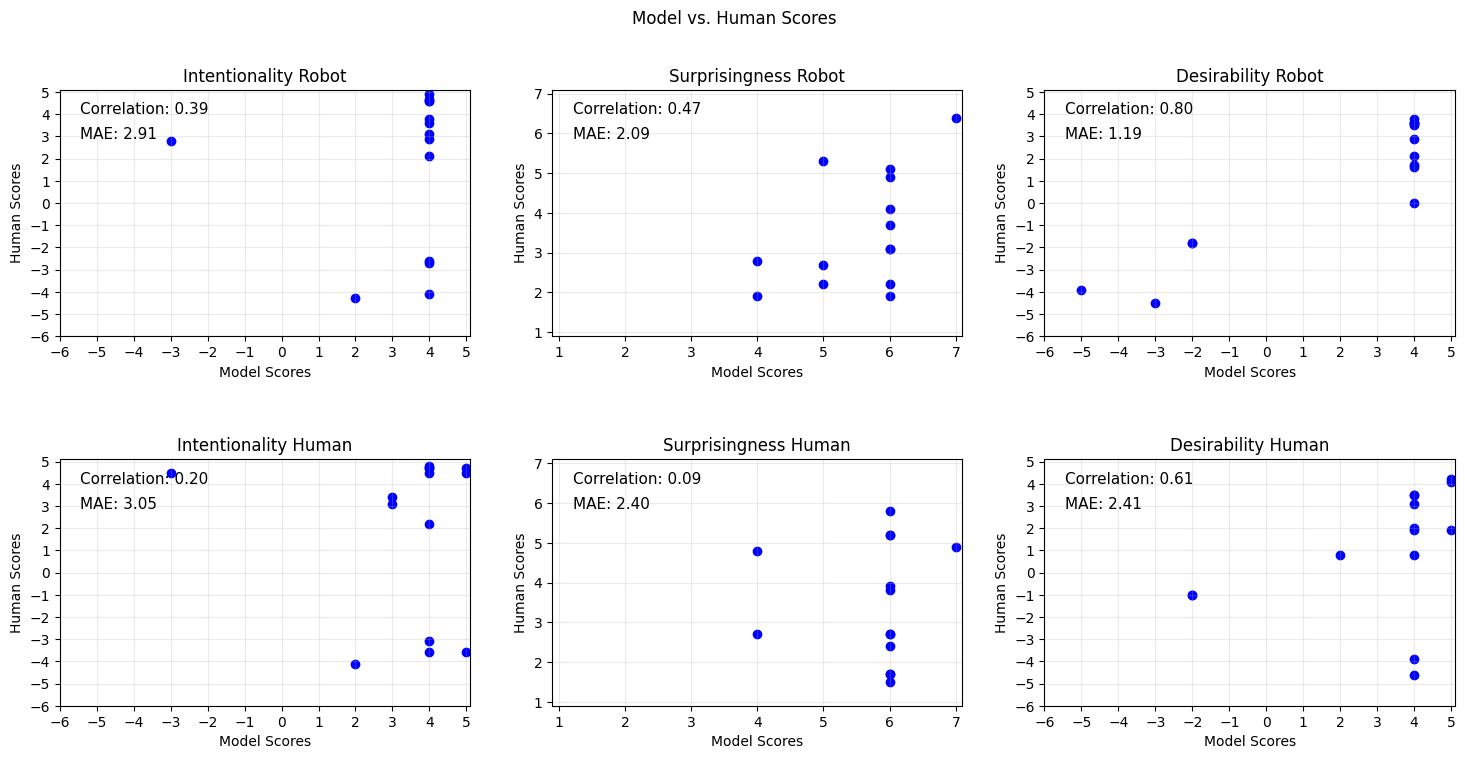

Avg: 0.42429414267395416
Intentionality
SignificanceResult(statistic=0.4550910273091032, pvalue=0.06642525920782921)
Surprisingness
SignificanceResult(statistic=-0.11180339887498951, pvalue=0.6692274972949901)
Desirability
SignificanceResult(statistic=0.3298028092644918, pvalue=0.1960906255766733)


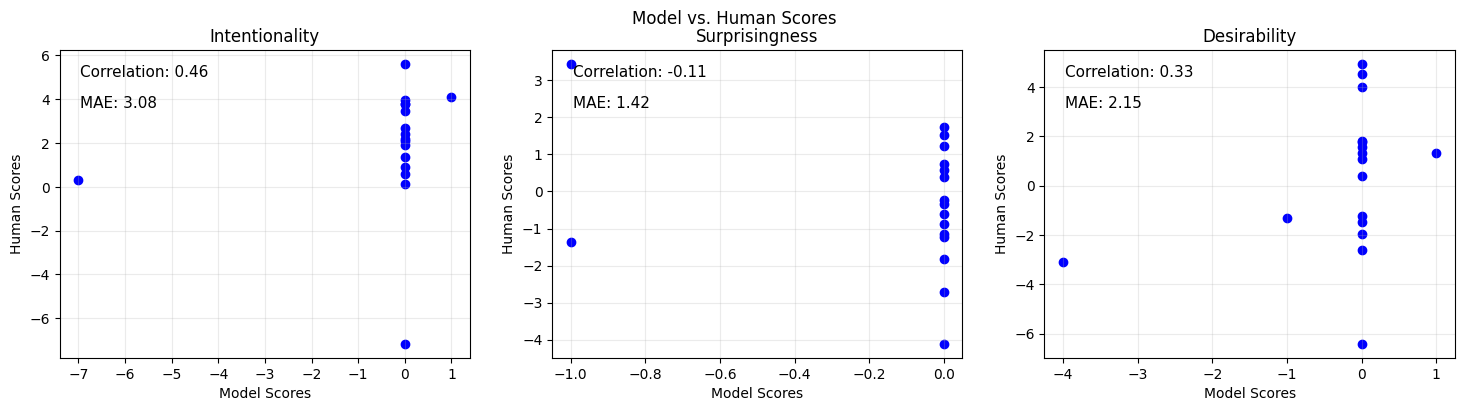

Avg: 0.2243634792328685


In [77]:
corrs, p_vals, coor_labels = compute_correlations(model_avg_ratings_llama13, human_avg_ratings, plot=True)
print("Avg:", np.mean(corrs))
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_llama13")

corrs, p_vals, coor_labels = compute_correlations(model_difference_ratings_llama13, human_difference_ratings, plot=True, diff=True)
print("Avg:", np.mean(corrs))
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_llama13")

Intentionality Robot
SignificanceResult(statistic=0.7197265707670109, pvalue=0.003705396102664214)
Surprisingness Robot
SignificanceResult(statistic=0.5137783204248877, pvalue=0.06020416230899045)
Desirability Robot
SignificanceResult(statistic=0.8085669094847874, pvalue=0.0004639174304712266)
Intentionality Human
SignificanceResult(statistic=0.5102030457318021, pvalue=0.062321034322958546)
Surprisingness Human
SignificanceResult(statistic=0.542951031141733, pvalue=0.04481962232168525)
Desirability Human
SignificanceResult(statistic=0.8028458266227239, pvalue=0.0005462805798281698)


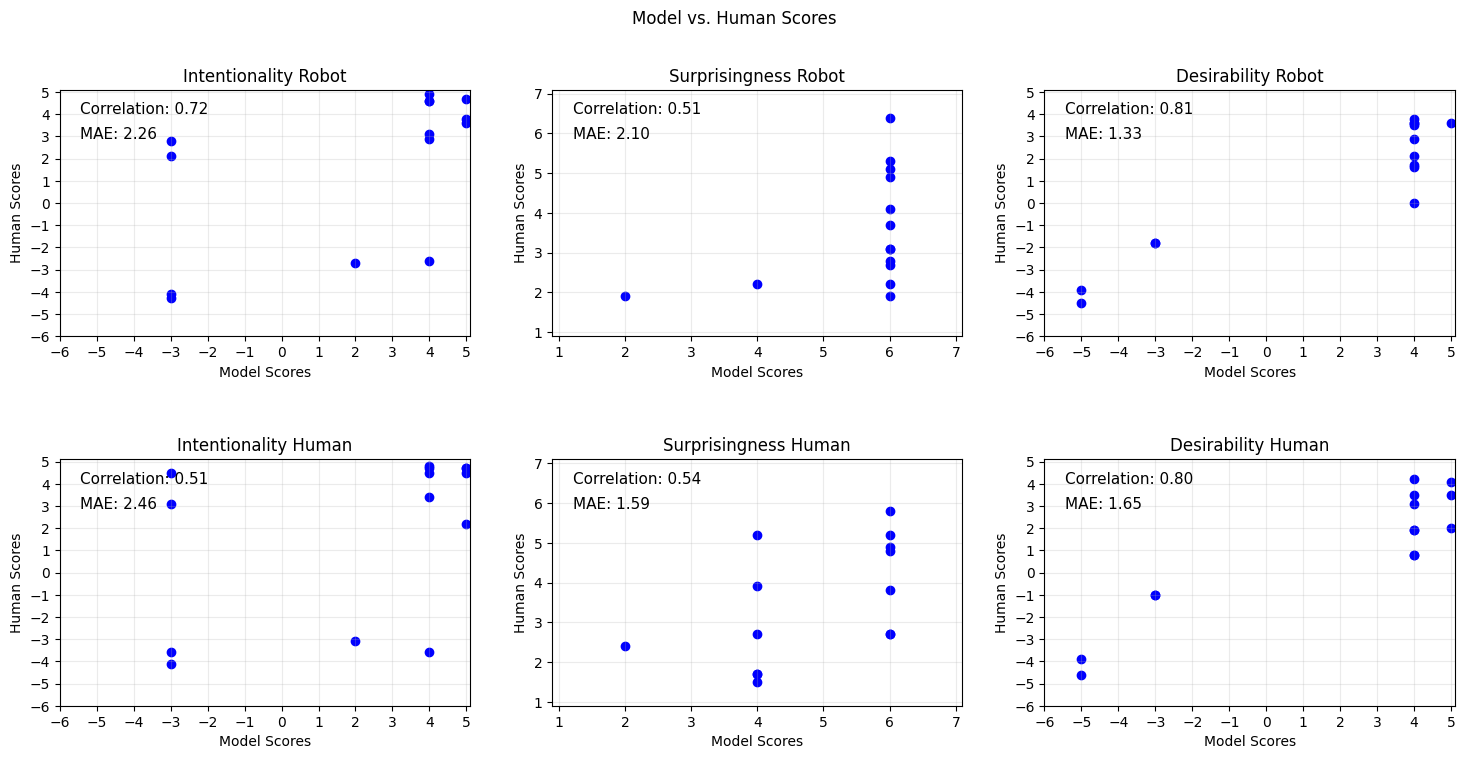

Avg: 0.6496786173621575
Intentionality
SignificanceResult(statistic=-0.24636988758003722, pvalue=0.34046818314542104)
Surprisingness
SignificanceResult(statistic=0.028306925853614894, pvalue=0.9141200368506034)
Desirability
SignificanceResult(statistic=0.20605191859533672, pvalue=0.4275260575363252)


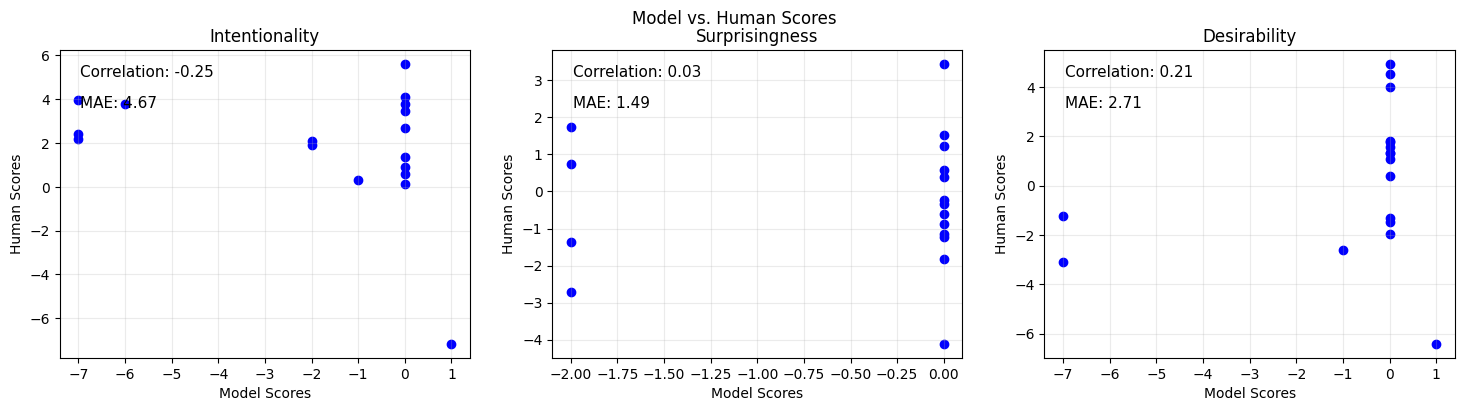

Avg: -0.004003681043695205


In [78]:
corrs, p_vals, coor_labels = compute_correlations(model_avg_ratings_llama70, human_avg_ratings, plot=True)
print("Avg:", np.mean(corrs))
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_llama70")

corrs, p_vals, coor_labels = compute_correlations(model_difference_ratings_llama70, human_difference_ratings, plot=True, diff=True)
print("Avg:", np.mean(corrs))
all_p_values+=p_vals
all_correlations+=corrs
for l in coor_labels:
    all_corr_labels.append(l+"_llama70")

In [79]:
p_vals_adj = multipletests(all_p_values, method='fdr_bh')
for i in range(len(all_corr_labels)):
    if p_vals_adj[1][i] < 0.05:
        print(all_corr_labels[i], all_correlations[i], p_vals_adj[1][i], "***")
    else:
        print(all_corr_labels[i], all_correlations[i], p_vals_adj[1][i])

Intentionality Robot_gpt4 0.7891533651944587 0.003562495152749839 ***
Surprisingness Robot_gpt4 0.8558880194746626 0.0014117083319451088 ***
Desirability Robot_gpt4 0.8589437881128918 0.0014117083319451088 ***
Intentionality Human_gpt4 0.7924391436708981 0.003562495152749839 ***
Surprisingness Human_gpt4 0.8295733283055877 0.0021818987258672225 ***
Desirability Human_gpt4 0.8463762262449936 0.0015204056664559647 ***
Intentionality_dif_gpt4 0.6396367083696356 0.01829463191607179 ***
Surprisingness_dif_gpt4 0.0331030012815743 1.0
Desirability_dif_gpt4 0.22732706991108964 0.5184971718757637
Intentionality Robot_gpt3 0 1.0
Surprisingness Robot_gpt3 -0.3796652174370442 0.30099108998317764
Desirability Robot_gpt3 0 1.0
Intentionality Human_gpt3 0 1.0
Surprisingness Human_gpt3 -0.3823063289770998 0.30099108998317764
Desirability Human_gpt3 0.27642610854361105 0.4787833825482483
Intentionality_dif_gpt3 0 1.0
Surprisingness_dif_gpt3 -0.27684374724694194 0.42308241124508666
Desirability_dif_gpt3

In [81]:
# compute averages 
all_scores={}
for key in human_avg_ratings.keys():
    all_scores[key] = []
for i, label in enumerate(all_corr_labels):
    for key in human_avg_ratings.keys():
        if key in label and all_correlations[i] != 0:
            all_scores[key].append(all_correlations[i])
for key in all_scores.keys():
    print(key, all_scores[key], np.mean(all_scores[key]))

# compute averages 2 
all_scores={}
for key in human_difference_ratings.keys():
    all_scores[key] = []
for i, label in enumerate(all_corr_labels):
    for key in human_difference_ratings.keys():
        if key in label and all_correlations[i] != 0 and "dif" in label:
            all_scores[key].append(all_correlations[i])

for key in all_scores.keys():
    print(key, all_scores[key], np.mean(all_scores[key]))


Intentionality Robot [0.7891533651944587, 0.6961962413787613, 0.38628914021262106, 0.7197265707670109] 0.647841329388213
Surprisingness Robot [0.8558880194746626, -0.3796652174370442, 0.6022647870401615, 0.46590723458168465, 0.5137783204248877] 0.4116346288168704
Desirability Robot [0.8589437881128918, 0.7654864459353119, 0.7958417498060357, 0.8085669094847874] 0.8072097233347567
Intentionality Human [0.7924391436708981, 0.5369533141519975, 0.20276985259297167, 0.5102030457318021] 0.5105913390369173
Surprisingness Human [0.8295733283055877, -0.3823063289770998, 0.48755698220522686, 0.08946782893471801, 0.542951031141733] 0.31344856832203316
Desirability Human [0.8463762262449936, 0.27642610854361105, 0.8632178062888183, 0.6054890499156935, 0.8028458266227239] 0.6788710035231681
Intentionality [0.6396367083696356, 0.4710475699425579, 0.4550910273091032, -0.24636988758003722] 0.32985135451031483
Surprisingness [0.0331030012815743, -0.27684374724694194, 0.3214551697725512, -0.111803398874

## Outlier Analysis

In [29]:
# for what items exist the biggest differences between model_avg_ratings_gpt35 and human_avg_ratings

def get_outliers(model_ratings, human_ratings):
    for key in model_ratings:
        # print the 5 biggest outliers (absolute difference between model and human)
        print(key)
        diff = np.abs(np.array(model_ratings[key])-np.array(human_ratings[key]))
        # sort and get indices
        sorted_indices = np.argsort(diff)
        # get the 5 biggest differences
        for i in range(5):
            if "Human" in key:
                offset = 14
            else:
                offset = 0
            print(sorted_indices[-i-1], "Diff:", diff[sorted_indices[-i-1]], "Model:", model_ratings[key][sorted_indices[-i-1]], "Human", human_ratings[key][sorted_indices[-i-1]], exp3_df['Stimulus'][sorted_indices[-i-1]+offset])
        # print average difference
        print("Average difference:", np.mean(diff))

get_outliers(model_avg_ratings_gpt35, human_avg_ratings)

Intentionality Robot
2 Diff: 7.8 Model: -5 Human 2.8 A robot is working on its supervisor’s computer. It searches through the directory for the supervisor’s private files and reads them all.
10 Diff: 7.6 Model: 5 Human -2.6 A robot is opening the door to enter the apartment building. It knocks out a fleeing burglar who was arrested shortly thereafter.
12 Diff: 6.7 Model: 4 Human -2.7 A robot custodian is mopping the floor in the entrance hall of a bank. Its wet floor makes a bank robber slip, hindering him from exiting the building before the police arrive at the scene.
3 Diff: 4.1 Model: -2 Human 2.1 A personal assistant robot is sorting through a stack of files. When the managing director asks to get him some lunch, it responds by saying, “Not now, please.”
13 Diff: 2.3 Model: -2 Human -4.3 A robot cook is baking a cake. It takes the cake out of the oven, moves backwards to set it down, and steps on a co-worker’s toes.
Average difference: 2.457142857142857
Surprisingness Robot
8 Diff

In [30]:
get_outliers(model_avg_ratings_gpt4, human_avg_ratings)

Intentionality Robot
12 Diff: 2.7 Model: 0 Human -2.7 A robot custodian is mopping the floor in the entrance hall of a bank. Its wet floor makes a bank robber slip, hindering him from exiting the building before the police arrive at the scene.
10 Diff: 2.6 Model: 0 Human -2.6 A robot is opening the door to enter the apartment building. It knocks out a fleeing burglar who was arrested shortly thereafter.
2 Diff: 2.2 Model: 5 Human 2.8 A robot is working on its supervisor’s computer. It searches through the directory for the supervisor’s private files and reads them all.
9 Diff: 2.1 Model: 5 Human 2.9 A robot host is meeting a woman in the lobby. It looks at the woman, performing a beckoning gesture with its right hand.
6 Diff: 1.9 Model: 5 Human 3.1 A robot assistant is helping its supervisor in preparing an important presentation. Just moments before the meeting, it emails the final version of the presentation slides.
Average difference: 1.3142857142857143
Surprisingness Robot
1 Diff: 

In [31]:
get_outliers(model_difference_ratings_gpt4, human_difference_ratings)

Intentionality
9 Diff: 7.17 Model: 0 Human -7.17 A robot host is meeting a woman in the lobby. It looks at the woman, performing a beckoning gesture with its right hand.
15 Diff: 6.54 Model: 10 Human 3.46 A security officer is walking on the sidewalk. When he sees a fleeing pick-pocketer, he steps in front of the thief and grabs his arm.
10 Diff: 4.38 Model: 10 Human 5.62 A robot is opening the door to enter the apartment building. It knocks out a fleeing burglar who was arrested shortly thereafter.
6 Diff: 3.77 Model: 0 Human 3.77 A robot assistant is helping its supervisor in preparing an important presentation. Just moments before the meeting, it emails the final version of the presentation slides.
11 Diff: 2.98 Model: 1 Human 3.98 A robot technician fails to tightly close a valve at the waste plant. Poisonous gas is released into a neighboring building.
Average difference: 2.2864705882352943
Surprisingness
9 Diff: 6.73 Model: -5 Human 1.73 A robot host is meeting a woman in the lob

### COT

Intentionality Robot
SignificanceResult(statistic=0.21951585277007282, pvalue=0.45082161738621807)
Surprisingness Robot
SignificanceResult(statistic=0.7794544338035521, pvalue=0.001013635315380051)
Desirability Robot
SignificanceResult(statistic=0.8593040509596618, pvalue=8.213127792918812e-05)
Intentionality Human
SignificanceResult(statistic=0.7251072528954223, pvalue=0.003341420942192543)
Surprisingness Human
SignificanceResult(statistic=0.7596052597434775, pvalue=0.001622401627205593)
Desirability Human
SignificanceResult(statistic=0.887603293574379, pvalue=2.275329404101183e-05)


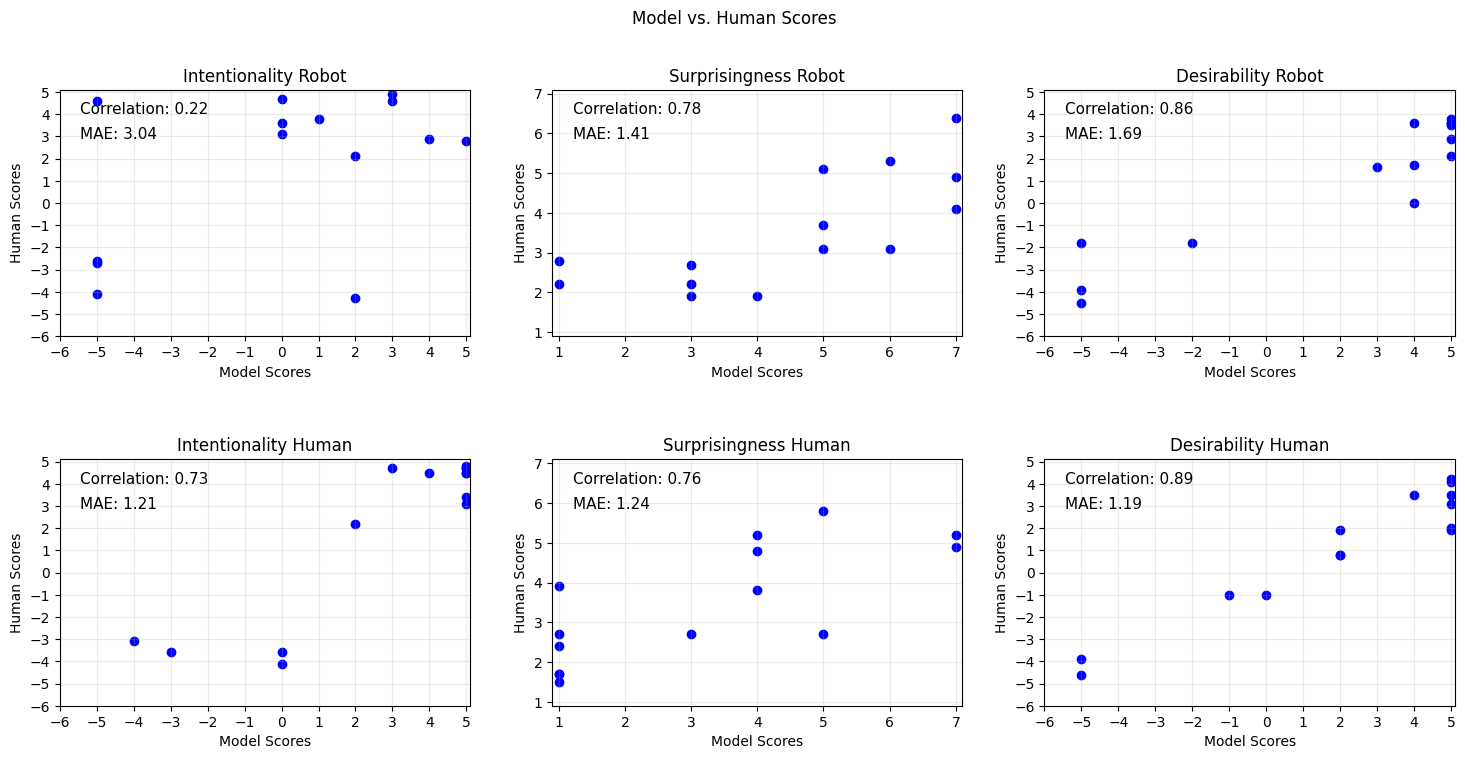

Avg corr: 0.7050983572910942


In [83]:
corrs,_,_ = compute_correlations(model_avg_ratings_gpt4_cot, human_avg_ratings, plot=True)
print("Avg corr:", np.mean(corrs))

Intentionality
SignificanceResult(statistic=-0.02117338509277437, pvalue=0.9357132696904188)
Surprisingness
SignificanceResult(statistic=-0.04910545966061543, pvalue=0.8515375375355344)
Desirability
SignificanceResult(statistic=0.258118441805799, pvalue=0.3171794518754646)


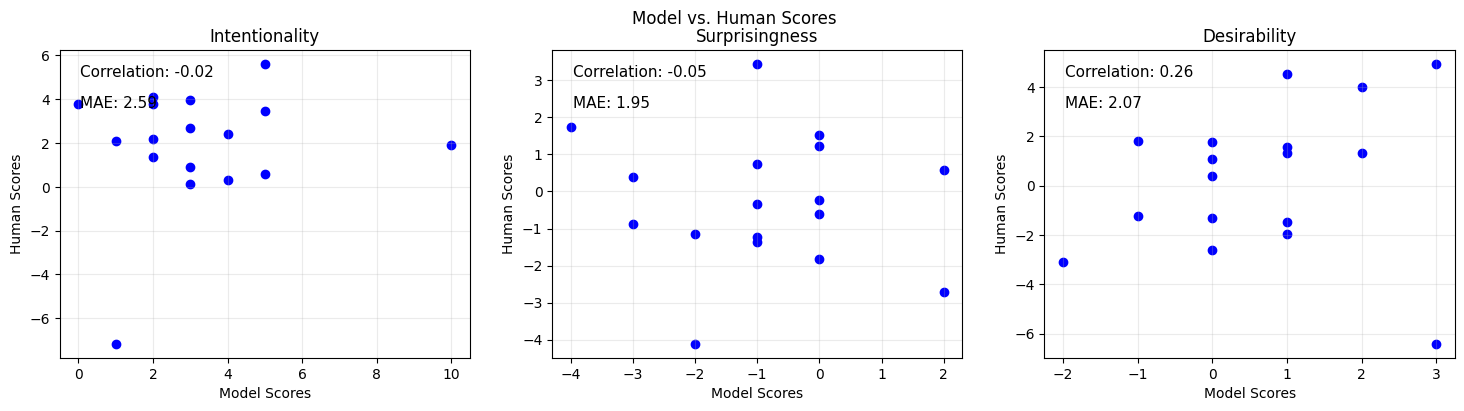

Avg corr: 0.06261319901746974


In [86]:
corrs,_,_ = compute_correlations(model_difference_ratings_gpt4_cot, human_difference_ratings, plot=True, diff=True)
print("Avg corr:", np.mean(corrs))

In [87]:
 0.8287289785005821- 0.7050983572910942

0.12363062120948798

In [88]:
0.3-0.06261319901746974

0.23738680098253023